<a href="https://colab.research.google.com/github/La-nuboj/Lanuboj/blob/master/MaskRCNN_test_using_Cloud_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/La-nuboj/Lanuboj.git

Cloning into 'Lanuboj'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [3]:
! git add .

fatal: not a git repository (or any of the parent directories): .git


In [0]:
!pip install segmentation-models --quiet
!pip install kaggle
!pip install albumentations

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c understanding_cloud_organization

100% 3.43G/3.44G [00:27<00:00, 151MB/s]
100% 3.44G/3.44G [00:27<00:00, 134MB/s]
100% 2.29G/2.30G [00:27<00:00, 53.5MB/s]
100% 2.30G/2.30G [00:27<00:00, 88.7MB/s]
 98% 53.0M/54.2M [00:00<00:00, 73.9MB/s]
100% 54.2M/54.2M [00:00<00:00, 81.8MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 94.7MB/s]


In [0]:
!unzip 'test_images.zip' -d ./test_images
!unzip 'train.csv.zip' -d ./train
!unzip 'train_images.zip' -d ./train_images

Archive:  test_images.zip
  inflating: ./test_images/0a3d2d8.jpg  
  inflating: ./test_images/406ac2a.jpg  
  inflating: ./test_images/83510ac.jpg  
  inflating: ./test_images/d219e77.jpg  
  inflating: ./test_images/25929c2.jpg  
  inflating: ./test_images/b0b75f6.jpg  
  inflating: ./test_images/b908920.jpg  
  inflating: ./test_images/00af77b.jpg  
  inflating: ./test_images/0b5d19e.jpg  
  inflating: ./test_images/e4c4e66.jpg  
  inflating: ./test_images/1c1fe23.jpg  
  inflating: ./test_images/d96dcf6.jpg  
  inflating: ./test_images/fd6c366.jpg  
  inflating: ./test_images/60cbb93.jpg  
  inflating: ./test_images/b827574.jpg  
  inflating: ./test_images/7aa292b.jpg  
  inflating: ./test_images/59c8638.jpg  
  inflating: ./test_images/9c43bff.jpg  
  inflating: ./test_images/638185f.jpg  
  inflating: ./test_images/5308baa.jpg  
  inflating: ./test_images/d24a663.jpg  
  inflating: ./test_images/8e8f768.jpg  
  inflating: ./test_images/fc8d2fb.jpg  
  inflating: ./test_images/7ecf

In [0]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm

In [0]:
train_df = pd.read_csv("./train/train.csv")
train_df = train_df.dropna()
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...




---



In [0]:
category_list = ["Fish","Flower","Gravel","Sugar"]

In [0]:
train_dict = {}
train_class_dict = {}
for idx, row in train_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    class_name = row.Image_Label.split("_")[1]
    class_id = category_list.index(class_name)
    if train_dict.get(image_filename):
        train_dict[image_filename].append(row.EncodedPixels)
        train_class_dict[image_filename].append(class_id)
    else:
        train_dict[image_filename] = [row.EncodedPixels]
        train_class_dict[image_filename] = [class_id]

In [0]:
df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
for key, value in train_dict.items():
  
    img = Image.open("./train_images/{}".format(key))
    width, height = img.width, img.height
    df = df.append({"image_id": key, "EncodedPixels": value, "CategoryId": train_class_dict[key], "Width": width, "Height": height},ignore_index=True)

In [0]:
df.head()

,image_id,EncodedPixels,CategoryId,Width,Height
0,0011165.jpg,[264918 937 266318 937 267718 937 269118 937 2...,"[0, 1]",2100,1400
1,002be4f.jpg,[233813 878 235213 878 236613 878 238010 881 2...,"[0, 1, 3]",2100,1400
2,0031ae9.jpg,[3510 690 4910 690 6310 690 7710 690 9110 690 ...,"[0, 1, 3]",2100,1400
3,0035239.jpg,[100812 462 102212 462 103612 462 105012 462 1...,"[1, 2]",2100,1400
4,003994e.jpg,[2367966 18 2367985 2 2367993 8 2368002 62 236...,"[0, 2, 3]",2100,1400


In [0]:
DATA_DIR = Path('./kaggle/input/')
ROOT_DIR = "./working"

NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [0]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.90 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [0]:
sys.path.append(ROOT_DIR+'/Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'


-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [0]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
class CloudDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("cloud", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("cloud", 
                           image_id=row.name, 
                           path='../train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)


In [0]:
print(CloudDataset(df.head()))

('../train_images/9243291.jpg', ['Flower', 'Sugar'])


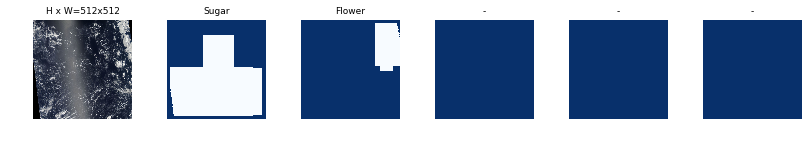

('../train_images/d4e1195.jpg', ['Flower', 'Sugar'])


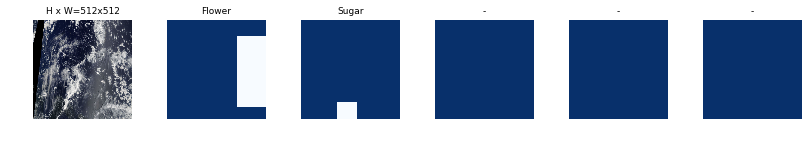

('../train_images/db5a703.jpg', ['Gravel', 'Sugar'])


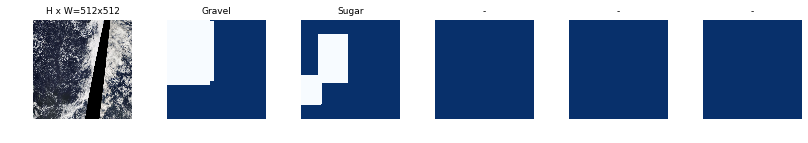

('../train_images/406c843.jpg', ['Flower', 'Gravel', 'Sugar'])


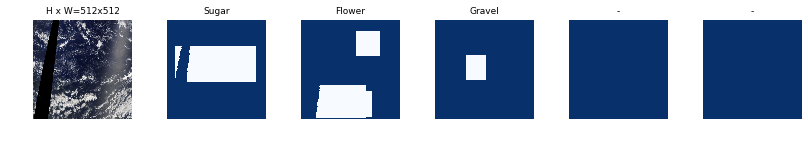

('../train_images/80dcbbd.jpg', ['Gravel', 'Sugar'])


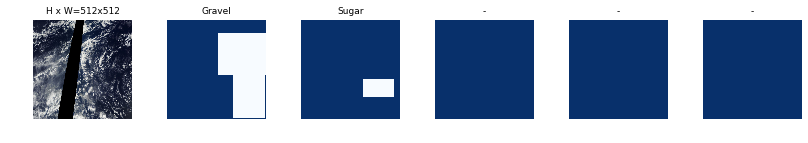

In [0]:
training_percentage = 0.9

training_set_size = int(training_percentage*len(df))
validation_set_size = int((1-training_percentage)*len(df))

train_dataset = CloudDataset(df[:training_set_size])
train_dataset.prepare()

valid_dataset = CloudDataset(df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

for i in range(5):
    image_id = random.choice(train_dataset.image_ids)
    print(train_dataset.image_reference(image_id))
    
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

In [0]:
LR = 1e-4
EPOCHS = [3,9]

import warnings 
warnings.filterwarnings("ignore")

In [0]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [0]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history

In [0]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [0]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()


In [0]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])


In [0]:
class InferenceConfig(CloudConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

In [0]:
glob_list = glob.glob(f'./working/cloud*/mask_rcnn_cloud_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

In [0]:
# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [0]:
sample_df = pd.read_csv("sample_submission.csv")
sample_df.head()

In [0]:
test_df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_df = test_df.append({"image_id": image_filename},ignore_index=True)
test_df = test_df.drop_duplicates()

In [0]:
test_df.head()

In [0]:
for i in range(8):
    image_id = test_df.sample()["image_id"].values[0]
    image_path = str('./test_images/'+image_id)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(12, 12))

# Submit predictions

In [0]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

In [0]:
submission_df = sample_df.copy()
submission_df["EncodedPixels"] = ""
with tqdm(total=len(test_df)) as pbar:
    for i,row in test_df.iterrows():
        pbar.update(1)
        image_id = row["image_id"]
        image_path = str('./test_images/'+image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0:
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

            #The following piece of code is creating rectangular masks from
            # the ROIs instead of using the masks drawn by the MaskRCNN.
            # It also removes any missing area from the imagery from the predicted masks.
            # Everything is added directly to the submission dataframe.
            rectangular_masks = []
            mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
            for roi, class_id in zip(rois, class_ids):
                rectangular_mask = np.zeros((512,512))
                rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
                img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
                cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
                kernel = np.ones((5,5),np.uint8)
                missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
                contour_mask = np.zeros(missing_data.shape)
                opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
                contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                if len(contours[0])>0:
                    largest_contour = max(contours[0], key = cv2.contourArea)
                    cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
                    kernel = np.ones((5,5),np.uint8)
                    opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
                    fixed_mask = np.where(opening[:,:]==255,0,255)
                    rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
                if mask_dict[category_list[class_id-1]]==[]:
                    mask_dict[category_list[class_id-1]] = rectangular_mask
                else:
                    previous_mask = mask_dict[category_list[class_id-1]].copy()
                    #prevents a bug where the mask is in int64
                    previous_mask = previous_mask.astype('float64')
                    boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
                    merged_mask = np.where(boolean_mask, 255, 0)
                    mask_dict[category_list[class_id-1]] = merged_mask

            
            #Going through the masks per category and create a md mask in RLE
            for cloud_category in mask_dict.keys():
                if mask_dict[cloud_category]!=[]:
                    #resizing for submission
                    resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
                    rle_str = rle_encoding(resized_mask)
                    image_label = "{}_{}".format(image_id,cloud_category)
                    submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
        else:
            masks, rois = r['masks'], r['rois']

In [0]:
submission_df.query("EncodedPixels!=''").head()

In [0]:
submission_df.to_csv("./working/submission.csv",index=False)